In [1]:
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from eg3d_dataset import EG3DDataset
from diffuser_utils.evaluate import evaluate_encoder, evaluate
from torchvision.models import convnext_base, convnext_small, efficientnet_v2_s

from accelerate import Accelerator
from diffusers import UNet1DModel
from diffusers import DDPMScheduler

from eg3d_pipeline import EG3DPipeline
from eg3d_encoder import EG3DEncoder
from eg3d_loss import EG3DLoss
from eg3d import EG3D

In [2]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    rgb = True
    image_size = 512  # the generated image resolution
    train_batch_size = 12
    eval_batch_size = 12  # how many images to sample during evaluation
    num_dataloader_workers = 12  # how many subprocesses to use for data loading
    encoder_epochs = 1
    diffuser_epochs = 1
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    scheduler_train_timesteps = 60
    eval_inference_steps = 60
    save_image_epochs = 1
    save_model_epochs = 5
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'eg3d-latent-diffusion'
    
    eg3d_model_path = 'eg3d/eg3d_model/ffhqrebalanced512-128.pkl'
    eg3d_latent_vector_size = 512
    
    data_dir = 'data_color/'
    df_file = 'dataset.df'

    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()

In [3]:
preprocess = transforms.Compose(
        [
            transforms.Resize(config.image_size),
            transforms.ToTensor(),
        ]
    )

dataset = EG3DDataset(df_file=config.df_file, data_dir=config.data_dir, transform=preprocess, encode=False)

train_size = int(len(dataset) * 0.95)
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size], generator=torch.Generator().manual_seed(42))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=config.num_dataloader_workers)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=config.eval_batch_size, shuffle=True, num_workers=config.num_dataloader_workers)

In [4]:
eg3d = EG3D(config.eg3d_model_path)

in_channels = 3 if config.rgb else 1
# encoder = EG3DEncoder(in_channels=3)
encoder = efficientnet_v2_s(num_classes=512)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [5]:
encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=config.learning_rate)
vector_loss_function = nn.L1Loss(reduction='mean')
eg3d_loss_function = EG3DLoss(model=eg3d, image_size=config.image_size)

In [6]:
def train_encoder_loop(config, model, optimizer, vector_loss_function, eg3d_loss_function, train_dataloader, eval_dataset):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        accelerator.init_trackers("eg3d_li_encoder")

    model, optimizer, train_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader
    )

    global_step = 0
    
    for epoch in range(config.encoder_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        model.train()
        
        for step, batch in enumerate(train_dataloader):
            images = batch['images']
            latent_vectors = batch['latent_vectors']
            
            with accelerator.accumulate(model):
                latent_vectors_pred = model(images)
                
                loss = vector_loss_function(latent_vectors_pred, latent_vectors) + eg3d_loss_function(latent_vectors_pred, images)
                accelerator.backward(loss)
                
                optimizer.step()
                # lr_scheduler.step()
                optimizer.zero_grad()
                
            progress_bar.update(1)
            logs = {"train_loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
        
        model.eval()
        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.encoder_epochs - 1:
                eval_loss = evaluate_encoder(config, epoch, model, eg3d_loss_function.get_eg3d(), vector_loss_function, eval_dataset)
                logs = {"eval_loss": eval_loss}
                accelerator.log(logs, step=global_step)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.encoder_epochs - 1:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, os.path.join(config.output_dir, f'encoder_{epoch}.pth'))

In [7]:
def train_diffuser_loop(config, model, encoder, noise_scheduler, optimizer, lr_scheduler, loss_function, eg3d, train_dataloader, eval_dataset):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        accelerator.init_trackers("eg3d_li_diffuser")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, encoder, optimizer, train_dataloader, lr_scheduler
    )
    
    encoder.eval()
    
    global_step = 0
    # Now you train the model
    for epoch in range(config.diffuser_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            images = batch['images']
            
            bs = images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=images.device).long()
            
            latent_vectors = batch['latent_vectors']
            predicted_latent_vectors = encoder(images)
            
            noise = latent_vectors - predicted_latent_vectors
            del latent_vectors
            
            noise = noise.unsqueeze(1)
            predicted_latent_vectors = predicted_latent_vectors.unsqueeze(1)
            
            predicted_latent_vectors = noise_scheduler.add_noise(predicted_latent_vectors, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(predicted_latent_vectors, timesteps, return_dict=False)[0]
                loss = loss_function(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = EG3DPipeline(encoder=encoder, unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, eg3d, eval_dataset)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir) 

In [8]:
from accelerate import notebook_launcher

In [8]:
args = (config, encoder, encoder_optimizer, vector_loss_function, eg3d_loss_function, train_dataloader, eval_dataset)

notebook_launcher(train_encoder_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/325 [00:00<?, ?it/s]

In [21]:
from diffusers.optimization import get_cosine_schedule_with_warmup

diffuser = UNet1DModel(
    sample_size=config.eg3d_latent_vector_size,  # the target image resolution
    in_channels=17,
    out_channels=1,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    # block_out_channels=(128, 128, 256, 128, 256, 256),  # the number of output channes for each UNet block
    # down_block_types=("DownBlock1DNoSkip", "DownBlock1D", "AttnDownBlock1D", "DownBlock1DNoSkip", "DownBlock1D", "AttnDownBlock1D"),
    # up_block_types=("AttnUpBlock1D", "UpBlock1D", "UpBlock1DNoSkip", "AttnUpBlock1D", "UpBlock1D", "UpBlock1DNoSkip"),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=config.scheduler_train_timesteps, prediction_type='epsilon')
optimizer = torch.optim.AdamW(diffuser.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.diffuser_epochs),
)

In [10]:
args = (config, diffuser, encoder, noise_scheduler, optimizer, lr_scheduler, vector_loss_function, eg3d, train_dataloader, eval_dataset)
encoder.eval()
notebook_launcher(train_diffuser_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/649 [00:00<?, ?it/s]

ValueError: The deprecation tuple ('predict_epsilon', '0.11.0', "Please make sure to instantiate your scheduler with `prediction_type` instead. E.g. `scheduler = DDPMScheduler.from_pretrained(<model_id>, prediction_type='epsilon')`.") should be removed since diffusers' version 0.12.0 is >= 0.11.0

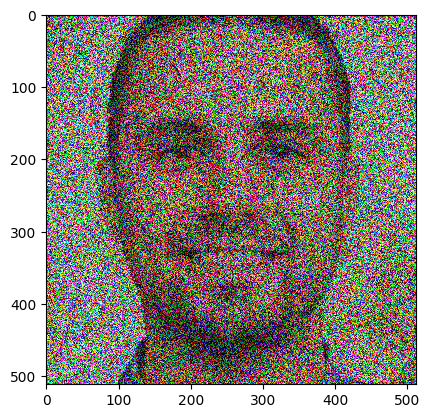

In [20]:
from matplotlib import pyplot as plt

image = eval_dataset[232]['images'].unsqueeze(0)
noise = torch.randn((3, 512, 512))
noisy_image = noise_scheduler.add_noise(image, noise, torch.Tensor([3]).type(torch.long))

# for t in reversed(range(3)):
#     noisy_image = noise_scheduler.step(noise, t, noisy_image).prev_sample
#     noise = noisy_image - image

noisy_image = noise_scheduler.step(noise, 3, noisy_image).prev_sample
plt.imshow((noisy_image.clip(0, 1).squeeze().cpu().numpy().transpose(1, 2, 0)), interpolation='nearest')
plt.show()

In [203]:
batch = eval_dataset[232]
images = batch['images'].unsqueeze(0).to('cuda')
latent_vectors = batch['latent_vectors'].unsqueeze(0).to('cuda')
predicted_latent_vectors = encoder(images)
noise = predicted_latent_vectors - latent_vectors

predicted_latent_vectors = predicted_latent_vectors.cpu()
noise = noise.cpu()

print(predicted_latent_vectors.amax())

predicted_latent_vectors = noise_scheduler.add_noise(latent_vectors.cpu(), noise, torch.Tensor([29]).type(torch.long))

print(predicted_latent_vectors.amax())

for t in reversed(range(noise_scheduler.num_train_timesteps)):
    timestep = torch.Tensor([t]).type(torch.long)
    predicted_latent_vectors = noise_scheduler.step(noise, timestep, predicted_latent_vectors).prev_sample
# predicted_latent_vectors = noise_scheduler.step(noise, 0, predicted_latent_vectors).prev_sample

print(noise.amax())
print(predicted_latent_vectors.amax())
print(latent_vectors.amax())

tensor(0.3186, grad_fn=<AmaxBackward0>)
tensor(0.8909, grad_fn=<AmaxBackward0>)
tensor(3.3224, grad_fn=<AmaxBackward0>)
tensor(0.9998, grad_fn=<AmaxBackward0>)
tensor(2.5682, device='cuda:0')
